In [1]:
# Visualizing convnet filters

In [2]:
# Another easy way to inspect the filters learned by convnets 
# is to display the visual pattern that each filter is meant to respond to. 
# This can be done with gradient ascent in input space: 
# applying gradient descent to the value of the input image of a convnet 
# so as to maximize the response of a specific filter, 
# starting from a blank input image. 
# The resulting input image will be one that the chosen filter is maximally responsive to.

In [3]:
import tensorflow as tf


tf.compat.v1.disable_eager_execution()

In [4]:
from keras.applications import VGG16
from keras import backend as K


model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

2022-07-27 14:06:44.452231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 14:06:44.455148: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-27 14:06:44.468271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [5]:
grads = K.gradients(loss, model.input)[0]

In [6]:
# A non-obvious trick to use to help the gradient-descent process go smoothly 
# is to normalize the gradient tensor by dividing it by its L2 norm 
# (the square root of the average of the square of the values in the tensor). 
# This ensures that the magnitude of the updates done to the input image is always within the same range.

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [7]:
import numpy as np


iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [8]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [9]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

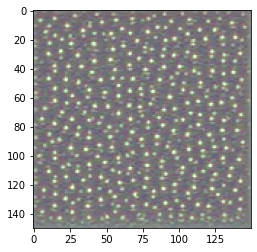

In [11]:
import matplotlib.pyplot as plt


plt.imshow(generate_pattern('block3_conv1', 0))

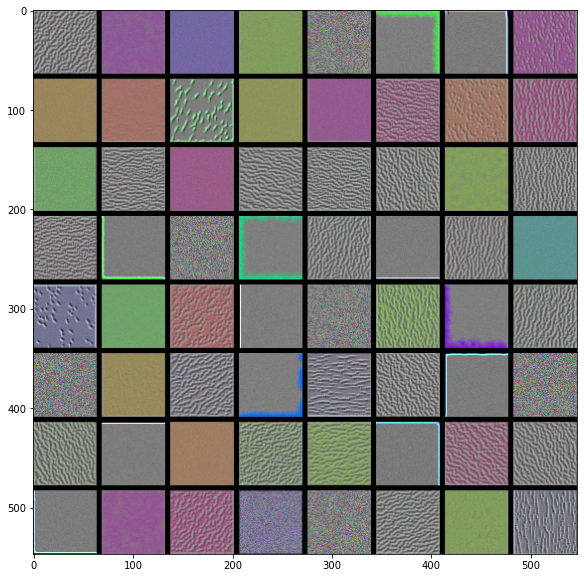

In [16]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
results = results.astype('uint8')

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(10, 10))
plt.imshow(results)